In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from typing import Dict, Tuple
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.stats import spearmanr, kendalltau
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Препроцессинг

In [3]:
! wget https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip -nc

File ‘chgk.zip’ already there; not retrieving.



In [4]:
with open('chgk/tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)
    
with open('chgk/results.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('chgk/players.pkl', 'rb') as f:
    players = pickle.load(f)

In [5]:
tournaments = pd.DataFrame.from_dict(tournaments).T

In [6]:
tournaments['dateStart'] = pd.to_datetime(tournaments['dateStart'], utc=True)
tournaments['dateEnd'] = pd.to_datetime(tournaments['dateEnd'], utc=True)

In [7]:
# взять в тренировочный набор турниры с dateStart из 2019 года; 
# в тестовый — турниры с dateStart из 2020 года.
tournaments_train = tournaments[tournaments['dateStart'].dt.year == 2019]
tournaments_test = tournaments[tournaments['dateStart'].dt.year == 2020]

In [8]:
def retrieve_mask(X: pd.DataFrame, results: Dict) -> pd.DataFrame:
    output = defaultdict(list)
    for idx in X['id'].values:
        if len(results[idx]) > 0:
            for i in range(0, len(results[idx])):
                if ('mask' in results[idx][i].keys()) and (results[idx][i]['mask'] is not None):
                    output['tournament_id'].append(idx)
                    output['mask'].append(results[idx][i]['mask'])
                    output['players_id'].append([results[idx][i]['teamMembers'][e]['player']['id'] for e in range(
                        0, len(results[idx][i]['teamMembers']))])
                    output['team_id'].append(results[idx][i]['team']['id'])
                    output['answered_question'].append(results[idx][i]['questionsTotal'])
                    output['position'].append(results[idx][i]['position'])
    return pd.DataFrame.from_dict(output)

In [9]:
results_train = retrieve_mask(tournaments_train, results)
results_test = retrieve_mask(tournaments_test, results)

In [10]:
train = pd.merge(tournaments_train, results_train, how='right', left_on='id', right_on='tournament_id')
test = pd.merge(tournaments_test, results_test, how='right', left_on='id', right_on='tournament_id')

In [11]:
train['questions_num'] = train['mask'].apply(lambda x: len(x))
test['questions_num'] = test['mask'].apply(lambda x: len(x))

In [12]:
train['type'] = train['type'].apply(lambda x: x['name'])
test['type'] = test['type'].apply(lambda x: x['name'])

In [13]:
train['type'].value_counts(normalize=True)

Синхрон              0.706304
Асинхрон             0.121829
Общий зачёт          0.088076
Обычный              0.081058
Строго синхронный    0.002733
Name: type, dtype: float64

In [14]:
train = train[train['type'].isin(['Синхрон', 'Обычный', 'Строго синхронный'])].reset_index(drop=True)
test = test[test['type'].isin(['Синхрон', 'Обычный', 'Строго синхронный'])].reset_index(drop=True)

In [15]:
def get_individual_player(X: pd.DataFrame) -> pd.DataFrame:
    output = defaultdict(list)
    for i in range(0, X.shape[0]):
        for player in X.loc[i, 'players_id']:
            output['tournament_id'].append(X.loc[i, 'id'])
            output['type'].append(X.loc[i, 'type'])
            output['questions_num'].append(X.loc[i, 'questions_num'])
            output['mask'].append(X.loc[i,'mask'])
            output['player_id'].append(player)
            output['team_id'].append(X.loc[i, 'team_id'])
            output['answered_question'].append(X.loc[i, 'answered_question'])
            output['team_position_in_tournament'].append(X.loc[i, 'position'])
    return pd.DataFrame.from_dict(output)

In [16]:
train = get_individual_player(train)
test = get_individual_player(test)

In [17]:
def add_player_name(X: pd. DataFrame, names:Dict) -> pd.DataFrame():
    for idx in range(0, X.shape[0]):
        cur_player = names[X.loc[idx, 'player_id']]
        X.loc[idx, 'player_name'] = cur_player['name'] + ' ' + cur_player['patronymic'] + ' ' + cur_player['surname']
    return X                   

In [18]:
train = add_player_name(train, players)
test = add_player_name(test, players)

In [19]:
players_ids = train['player_id'].unique()
tournaments_ids = train['tournament_id'].unique()
players_new_id_dict = {k: i for i, k in enumerate(players_ids)}
tournament_new_id_dict = {k: i for i, k in enumerate(tournaments_ids)}

In [20]:
train['new_player_id'] = train['player_id'].map(players_new_id_dict)
test['new_player_id'] = test['player_id'].map(players_new_id_dict)

train['new_tournament_id'] = train['tournament_id'].map(tournament_new_id_dict)
test['new_tournament_id'] = test['tournament_id'].map(tournament_new_id_dict)

In [21]:
# раздадим каждому вопросу турнира свой айдишник
initial_question_num = train.loc[0, 'questions_num']
questions_dict = dict(train.groupby('new_tournament_id')['questions_num'].max().cumsum() - initial_question_num)

In [22]:
# получу пары вопрос/игрок и (0, 1) - ответил игрок или нет
X = []
y = []

for mask, player, tournament_id  in zip(train['mask'], train['new_player_id'], train['new_tournament_id']):
    for i, answer in enumerate(mask):
        if answer == '1':
            answer = 1
        else:
            answer = 0
        question_id = questions_dict[tournament_id] + i
        X.append([question_id, player])
        y.append(answer)
        
X_train, y_train = np.array(X), np.array(y)

In [23]:
max_question_num = train.groupby('new_tournament_id')['questions_num'].max().cumsum().max()

In [24]:
def ohe(X: pd.DataFrame) -> csr_matrix:
    rows = np.repeat(np.arange(X.shape[0]), 2)
    cols = X.copy()
    cols[:,1] += max_question_num + 1
    cols = cols.ravel()
    values = np.ones(X.shape[0] * 2, dtype=np.uint8)
    ohe = csr_matrix((values, (rows, cols)), dtype=np.uint8)
    return ohe

In [25]:
X_train_ohe = ohe(X_train)

In [26]:
X_train_ohe.shape, y_train.shape

((14661596, 73912), (14661596,))

# Часть 2 - рейтинг-лист игроков

In [27]:
log_reg = LogisticRegression(fit_intercept=False)

In [28]:
log_reg.fit(X_train_ohe, y_train)

LogisticRegression(fit_intercept=False)

In [29]:
weights = log_reg.coef_[0, max_question_num + 1:]
rating = {i: weight for i, weight in enumerate(weights)}

In [30]:
players_rating = train[['player_name', 'new_player_id']].drop_duplicates(subset=['new_player_id'])
players_rating['rating'] = players_rating['new_player_id'].map(rating)
players_rating = players_rating.sort_values(by='rating', ascending=False).reset_index(drop=True)

In [31]:
 players_rating.head(15)

,player_name,new_player_id,rating
0,Максим Михайлович Руссо,8222,3.145146
1,Александра Владимировна Брутер,5957,3.035830
2,Иван Николаевич Семушин,1209,3.006972
3,Михаил Владимирович Савченков,1208,2.910524
4,Сергей Леонидович Спешков,8244,2.844223
5,Артём Сергеевич Сорожкин,155,2.826968
6,Станислав Григорьевич Мереминский,1210,2.684174
7,Михаил Ильич Левандовский,2,2.572391
8,Антон Владимирович Саксонов,9661,2.569687
9,Ирина Сергеевна Прокофьева,5,2.561374


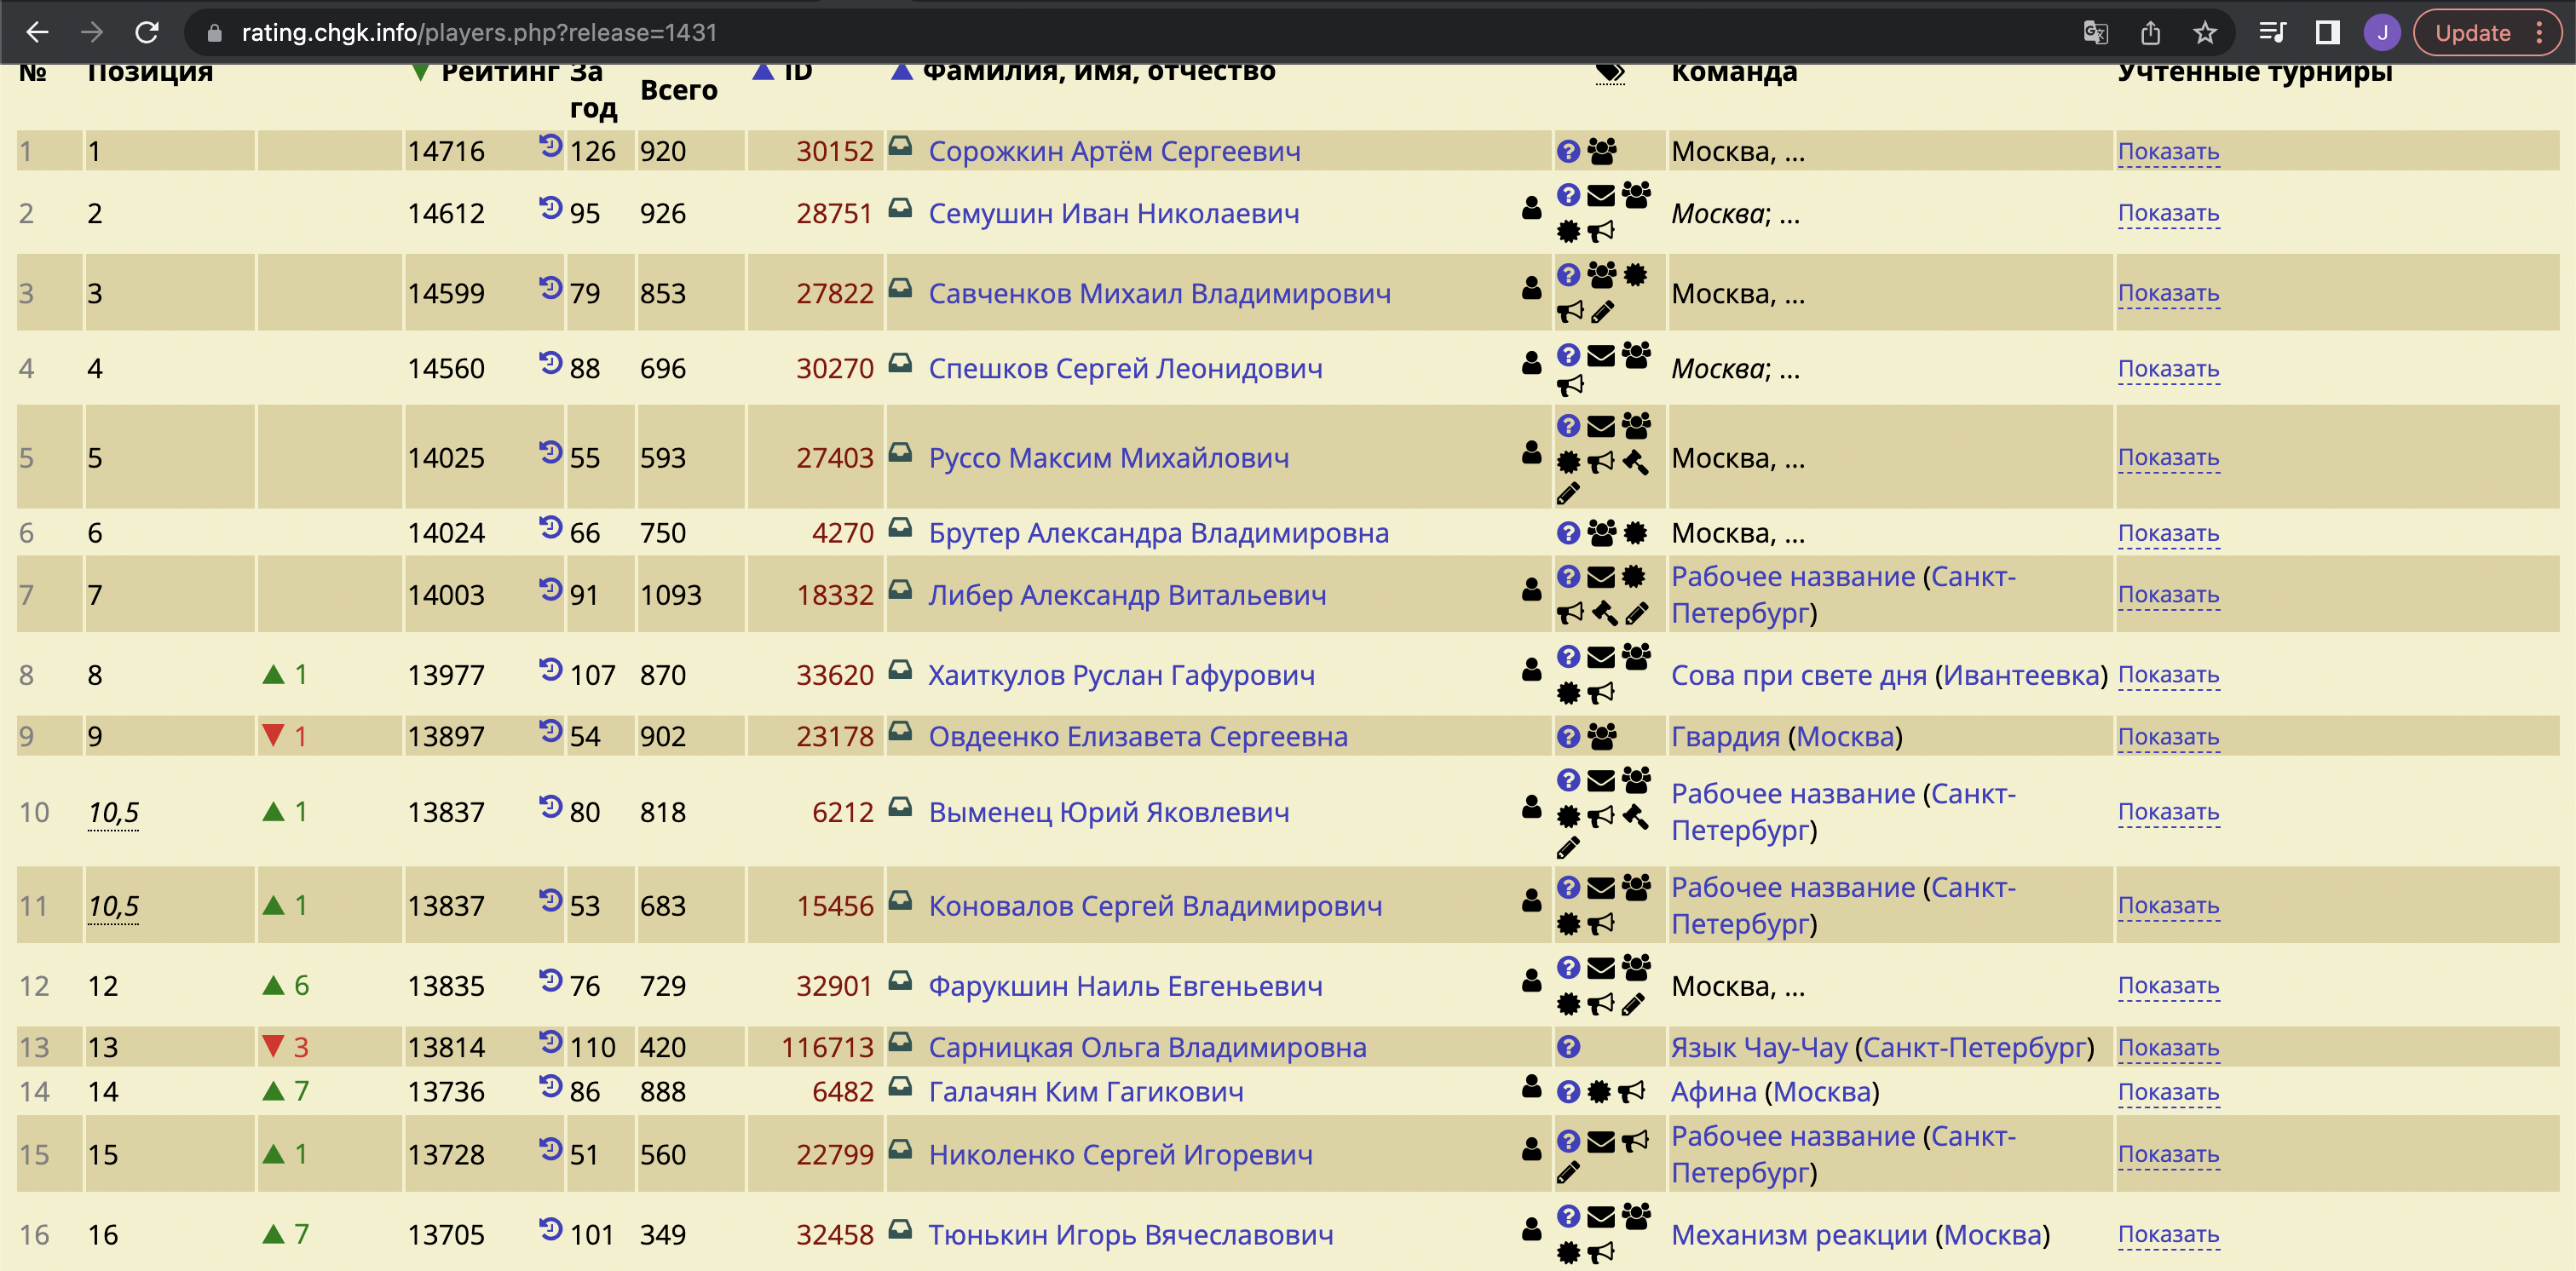

In [57]:
Image('rating.png')

In [32]:
players_rating.tail()

,player_name,new_player_id,rating
44724,Виктор Геннадиевич Карабанов,33130,-3.653501
44725,Анна Михайловна Никитина,33129,-3.662084
44726,Миралина Дамировна Салихова,40773,-3.743490
44727,Виктория Константиновна Белицкая,39752,-3.768551
44728,Елена Павловна Соловьёва,39749,-3.768551


В целом, результаты хорошие. Топовые игроки попали в начало рейтинга (https://rating.chgk.info/players.php). При этом, есть небольшие отклонения в порядке расположения. Например, Станислав Григорьевич Мереминский в 2020 году занимал 31 место (https://rating.chgk.info/player/20691?display_player_stats), а у модели получил 7, Михаил Ильич Левандовский на 30 месте, а в рейтинге модели 8, но я ожидала куда худших результатов =)
 
 Низ рейтинга тоже выглядит правдоподобно. Так, Карабанов Виктор Геннадиевич участвовал в 2 играх из рейтинга и занимал 962 и 1211 место в них, данных о рейтинге Никитиной Анны Михайловны, Салиховой Миралины Дамировны и Соловьёвой Елены Павловны я не нашла на сайте, Белицкая Виктория Константиновна участвовала в 3 играх, занимая 736, 665 и 524 места.

# Часть 3 - ранжирование команд

In [34]:
def get_correlation(df: pd.DataFrame, pred_rating: pd.DataFrame) -> Tuple[np.array, np.array]:
    spearman_corr = []
    kendall_corr = []
    for _, game in df.groupby('tournament_id'):
        y_true = []
        y_pred = []
        for _, team in game.groupby('team_id'):
            y_true.append(team['answered_question'].iloc[0] / team['questions_num'].iloc[0]) 
            players = team['new_player_id'].unique()
            pred_team_rating = np.array([pred_rating[pred_rating['new_player_id'] == player]['rating'].max() 
                                         for player in players])
            # считаю, что рейтинг команды - это усредненный рейтинг всех участников (идея навеяна рейтингом Эло)
            rating = pred_team_rating.mean() 
            y_pred.append(rating)
        s_corr, _ = spearmanr(y_true, y_pred)
        k_corr, _ = kendalltau(y_true, y_pred)
        spearman_corr.append(s_corr)
        kendall_corr.append(k_corr)
    return np.array(spearman_corr), np.array(kendall_corr)

In [35]:
spearman_train, kendall_train = get_correlation(train, players_rating)

In [36]:
# турниры 2019 года
spearman_train[~np.isnan(spearman_train)].mean(), kendall_train[~np.isnan(kendall_train)].mean()

(0.8491500122147879, 0.7049494571333901)

In [37]:
spearman_test, kendall_test = get_correlation(test, players_rating)

In [38]:
# турниры 2020 года
spearman_test[~np.isnan(spearman_test)].mean(), kendall_test[~np.isnan(kendall_test)].mean()

(0.7048910109548349, 0.6267380089907143)

# Часть 4 - EM-схема

То, что на вопрос могут отвечать сразу несколько игроков попробую учесть через вероятность правильного ответа команды. На шаге Е через вероятность ответить на вопрос правильно отдельного участника команды буду оценивать вероятность всей команды дать правильный ответ, дальше нормировать вероятность для игрока на вероятность команды и полученные значения подсовывать в модель на шаге М в качестве весов

In [39]:
# сделаю табличку вида вопрос-команда-ответ
def create_team_answer_df(df: pd.DataFrame, questions_dict: Dict) -> pd.DataFrame:
    team_id_list = []
    question_num_list = []
    answer_list = []
    for tournament_id, team_id, mask in zip(df['new_tournament_id'], df['team_id'], df['mask']):
        team_id_list.extend([team_id] * len(mask))  
        question_num_list.extend([questions_dict[tournament_id] + i for i in range(len(mask))])
        answer_list.extend([1 if answer == '1' else 0 for answer in mask])
    return pd.DataFrame({'question_num': question_num_list, 'team_id': team_id_list, 'answer': answer_list})

In [40]:
train_info = create_team_answer_df(train, questions_dict) 

In [41]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def e_step(model: object, X: csr_matrix, team_answer_df: pd.DataFrame) -> np.array:
    pred = model.predict(X)
    pred_proba = sigmoid(pred)
    df = team_answer_df.copy()
    df['player_win_proba'] = pred_proba
    team_win_proba = df.groupby(['question_num',
                                 'team_id'])['player_win_proba'].apply(lambda x: 
                                                                       1-np.prod(1-x)).rename('team_win_proba')
    df = df.merge(team_win_proba, left_on=['question_num', 'team_id'], right_index=True)
    df['player_in_team_win_proba'] = df['player_win_proba'] / df['team_win_proba']
    return df['player_in_team_win_proba'].values


def m_step(model: object, X: csr_matrix, y: np.array, e_step_players_probas: np.array) -> object:
    model.fit(X, y, sample_weight=e_step_players_probas)
    return model

In [42]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train_ohe, y_train)
for i in range(5):
    print(f'Шаг {i}')
    expected_player_probas = e_step(model, X_train_ohe, train_info)
    model = m_step(model, X_train_ohe, y_train, expected_player_probas)
    # вношу в табличку обновленный рейтинг игроков
    weights = model.coef_[max_question_num + 1:]
    new_rating = {i: weight for i, weight in enumerate(weights)}
    players_rating = players_rating.drop('rating', axis=1)
    players_rating['rating'] = players_rating['new_player_id'].map(new_rating)
    players_rating = players_rating.sort_values(by='rating', ascending=False).reset_index(drop=True)
    
    spearman_, kendall_ = get_correlation(train, players_rating)
    print(spearman_[~np.isnan(spearman_)].mean(), kendall_[~np.isnan(kendall_)].mean())

Шаг 0
0.8507744784213995 0.7066472728850401
Шаг 1
0.8507865551860868 0.7067141626221534
Шаг 2
0.8507659163220027 0.7066823103709186
Шаг 3
0.8507659228728103 0.7066824386465838
Шаг 4
0.8507659228728103 0.7066824386465838


In [43]:
players_rating.head(15)

,player_name,new_player_id,rating
0,Дмитрий Олегович Вальтер,28259,0.702820
1,Максим Михайлович Руссо,8222,0.684353
2,Александра Владимировна Брутер,5957,0.661183
3,Максим Игоревич Пилипенко,36151,0.661053
4,Иван Николаевич Семушин,1209,0.659574
5,Дмитрий Сергеевич Кудинов,18657,0.654412
6,Михаил Владимирович Савченков,1208,0.651751
7,Сергей Леонидович Спешков,8244,0.644009
8,Артём Сергеевич Сорожкин,155,0.639253
9,Анастасия Борисовна Калинина,18369,0.625464


In [44]:
players_rating.tail()

,player_name,new_player_id,rating
44724,Артемий Николаевич Леготин,24136,-0.529887
44725,Артём Романович Громов,24139,-0.531487
44726,Иван Васильевич Нестеренко,24140,-0.566958
44727,Александр Александрович Павлов,24141,-0.567117
44728,Илья Денисович Корешков,24142,-0.567925


In [45]:
players_rating[players_rating['player_name'] == 'Сергей Игоревич Николенко']

,player_name,new_player_id,rating
29,Сергей Игоревич Николенко,3,0.592033


Топовые игроки по-прежнему остались вверху рейтинга, хотя и поменялись местами, некоторые игроки переместились чуть ниже. Абсолютные значения рейтинга изменились.
Не думаю, что моя попытка имитации ЕМ-алгоритм получилась успешной, корреляции немного увеличились, но как-то подозрительно быстро сошлись.

# Часть 5 - рейтинг вопросов

In [46]:
questions_weights = log_reg.coef_[:max_question_num + 1]

In [77]:
tournament_rating = {}
i = 0
for new_tournament_id in train['new_tournament_id'].unique():
    questions_in_tournament = []
    for _ in range(train[train['new_tournament_id'] == new_tournament_id]['questions_num'].max()):
        questions_in_tournament.append(questions_weights[0][i-1])
        i += 1
    tournament_rating[new_tournament_id] = np.mean(questions_in_tournament)

In [78]:
train['tournament_rating'] = train['new_tournament_id'].map(tournament_rating)

In [79]:
tournament_complexity = train.drop_duplicates(subset=['tournament_id']).sort_values(by='tournament_rating', 
                                                                                    ascending=True)

tournament_complexity = tournament_complexity[['tournament_id', 'tournament_rating']]
tournament_complexity = pd.merge(tournament_complexity, tournaments_train[['id', 'name']], 
                                 left_on='tournament_id', right_on='id', how='inner')

In [80]:
tournament_complexity.head(10)

,tournament_id,tournament_rating,id,name
0,6150,-4.359593,6150,Чемпионат Санкт-Петербурга. Высшая лига
1,5159,-2.807255,5159,Первенство правого полушария
2,5684,-2.757797,5684,Синхрон высшей лиги Москвы
3,5587,-2.387906,5587,Записки охотника
4,5928,-2.379847,5928,Угрюмый Ёрш
5,5083,-2.271441,5083,Ускользающая сова
6,5421,-2.254231,5421,Львов зимой. Адвокат
7,5515,-2.244787,5515,Чемпионат Минска. Лига А. Тур четвёртый
8,5693,-2.235356,5693,Знание – Сила VI
9,5942,-2.199158,5942,Чемпионат Мира. Этап 2. Группа В


In [81]:
tournament_complexity.tail(10)

,tournament_id,tournament_rating,id,name
602,5967,0.487970,5967,ОЧВР. 3 тур
603,5128,0.522559,5128,Лига Сибири. IV тур.
604,5570,0.544742,5570,Турнир малых факультетов МГУ
605,5457,0.614584,5457,Студенческий чемпионат Калининградской области
606,5511,0.652327,5511,KFC
607,5130,0.660385,5130,Лига Сибири. VI тур.
608,5728,0.704855,5728,Синхрон-lite. Выпуск XXIX
609,5855,0.762329,5855,Лига вузов. IV тур
610,5729,0.790291,5729,Синхрон-lite. Выпуск XXX
611,5438,1.481756,5438,Синхрон Лиги Разума


Школьные лиги, я, видимо, отфильтровала, когда убрала "опасные" типы турниров, воспользовавшись советом игроков, но по-моему выглядит более-менее логично. Игры с добавкой -lite модель отнесла к простым, а Первенство правого полушария, Чемпионат Мира - к сложным.